#### Santander Customer Transaction Prediction
Esse dataset foi disponibilizado na plataforma Kaggle pelo banco Santander em uma competição de algoritmos para classificação binária, disponível em: https://www.kaggle.com/competitions/santander-customer-transaction-prediction/data

"In this challenge, we need to identify which customers will make a specific transaction in
the future, irrespective of the amount of money transacted."

No dataset temos o desafio de identificar quais clientes farão uma transação específica no futuro independentemente do valor dela.

### Análise Exploratória de Dados.
Começamos por:

→Carregar o dataset e as bibliotecas

→Visualização dos tipos de dados e limpezas (se necessário)

→Visualização da variável target

→Dados faltantes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, StratifiedKFold
import eli5
from eli5.sklearn import PermutationImportance
import graphviz
from pdpbox import pdp, get_dataset, info_plots
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt
from scikitplot.metrics import plot_confusion_matrix,plot_precision_recall_curve
from sklearn.metrics import roc_auc_score,confusion_matrix,make_scorer,classification_report,roc_curve,auc
import lightgbm as lgb
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('C:/Users/Urbanek/Documents/Data Science/Datasets/Santander Customer Transaction Prediction Dataset/train.csv')

In [3]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [5]:
df['target'].value_counts()

0    179902
1     20098
Name: target, dtype: int64

In [6]:
df['target'].value_counts()/len(df)*100

0    89.951
1    10.049
Name: target, dtype: float64

In [7]:
faltantes_perc = df.isnull().sum() / len(df['target'])* 100
faltantes_perc

ID_code    0.0
target     0.0
var_0      0.0
var_1      0.0
var_2      0.0
          ... 
var_195    0.0
var_196    0.0
var_197    0.0
var_198    0.0
var_199    0.0
Length: 202, dtype: float64

In [8]:
df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


<AxesSubplot:ylabel='count'>

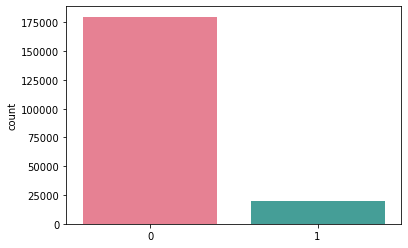

In [9]:
plt.plot(figsize=(20,5))
sns.countplot(df.target.values,palette='husl')

### Algumas considerações:
Temos um dataset com 200 mil linhas das quais não temos informações faltantes. A variavel target possui ~90% de um tipo de dado, o que faz com que nosso dataset não esteja "equilibrado". Os dados nos mostram que 90% dos clientes não tem interesse em fazer novas transações. O plot em violino nos mostra que há uma distribuição homogenea de ambos os dados 'target' em relação ao índice

### Distrubuição dos atributos e trends
Agora podemos chegar como está a distribuição dos atributos e as possíveis trends do dataset

In [10]:
def plot_dist_at_treino(t0, t1, label1, label2, at_treino):
    i=0
    sns.set_style('whitegrid')
    
    fig=plt.figure()
    ax=plt.subplots(10,10,figsize=(22,18))
    
    for atrib in at_treino:
        i+=1
        plt.subplot(10,10,i)
        sns.distplot(t0[atrib],hist=False,label=label1)
        sns.distplot(t1[atrib],hist=False,label=label2)
        plt.legend()
        plt.xlabel('Attribute',)
        sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    plt.show()

Definiremos t0 como os clientes que não farão uma transação e t1 para os que farão.

In [11]:
t0 = df[df.target.values == 0]
t1 = df[df.target.values == 1]

Para facilitar a visualização faremos dois conjuntos de 100 atributos.

<Figure size 432x288 with 0 Axes>

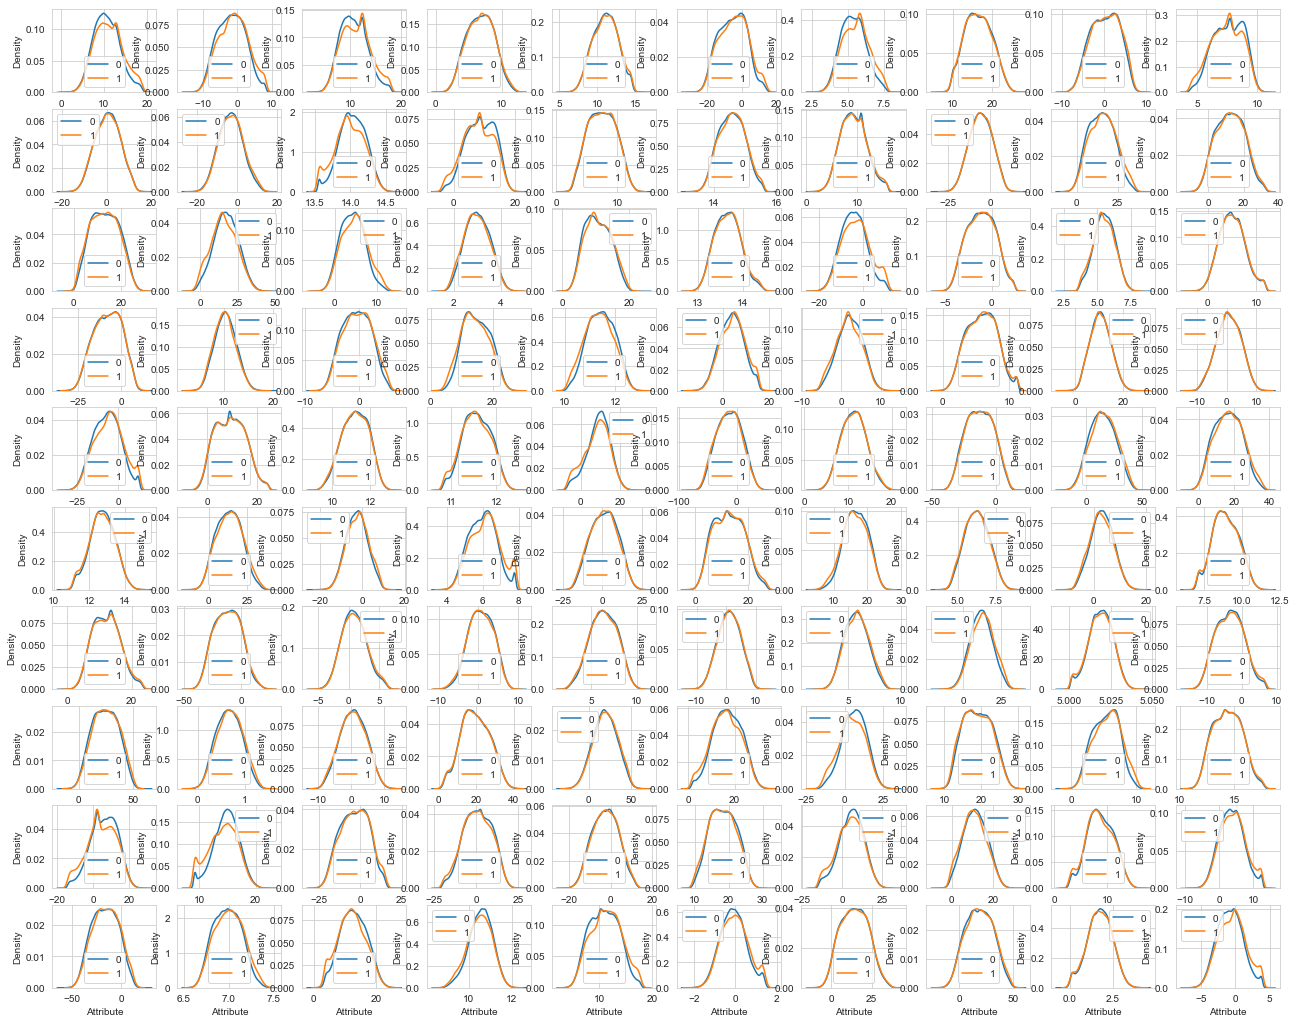

In [12]:
at_treino = df.columns.values[2:102]
plot_dist_at_treino(t0,t1,'0','1',at_treino)

<Figure size 432x288 with 0 Axes>

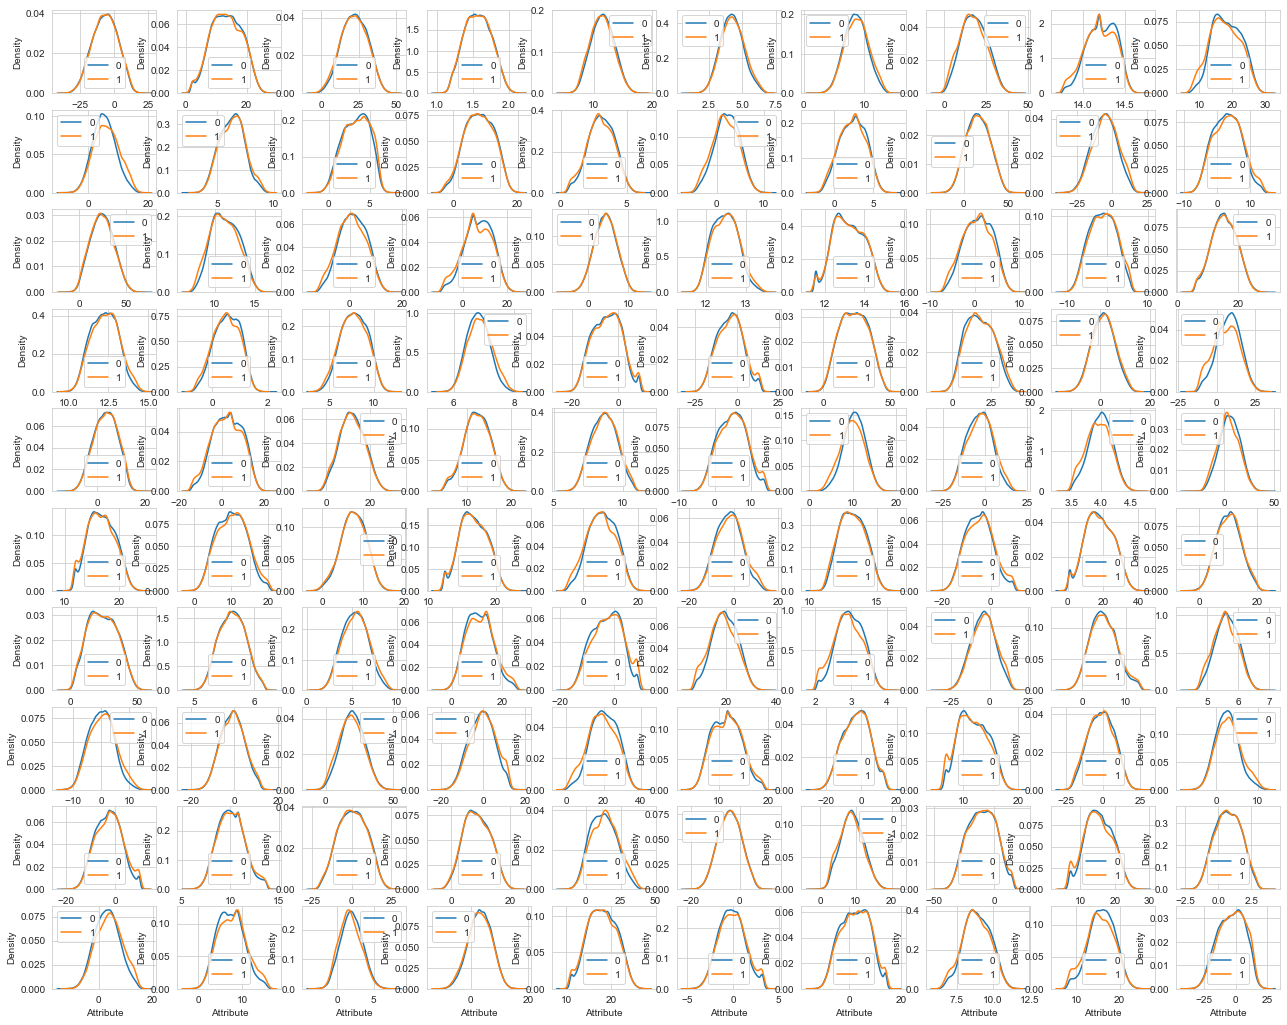

In [13]:
at_treino = df.columns.values[102:203]
plot_dist_at_treino(t0,t1,'0','1',at_treino)

Podemos perceber pelos gráficos que existe uma consideravel quantidade de features igualmente distribuidas para os dois grupos (ex: var_3,var_7,var_10, etc) E também features que tem distribuições bem diferentes (ex: var_0,var_1,var_9, etc)

Vamos testar as features do dataset de teste pra ver se o padrão se mantém.

In [14]:
test_df = pd.read_csv('C:/Users/Urbanek/Documents/Data Science/Datasets/Santander Customer Transaction Prediction Dataset/test.csv')

In [15]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [16]:
test_df.shape

(200000, 201)

Como no dataset test não temos o gabarito do target vamos plotar apenas a distribuição das features

In [17]:
def plot_test_features(test_features):
    i=0
    sns.set_style('whitegrid')
    
    fig=plt.figure()
    ax=plt.subplots(10,10,figsize=(22,18))
    
    for att in test_features:
        i+=1
        plt.subplot(10,10,i)
        sns.distplot(test_df[att],hist=False)
        plt.xlabel('Attribute',)
        sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    plt.show()

Também dividiremos os dados da mesma forma para uma melhor visualização

<Figure size 432x288 with 0 Axes>

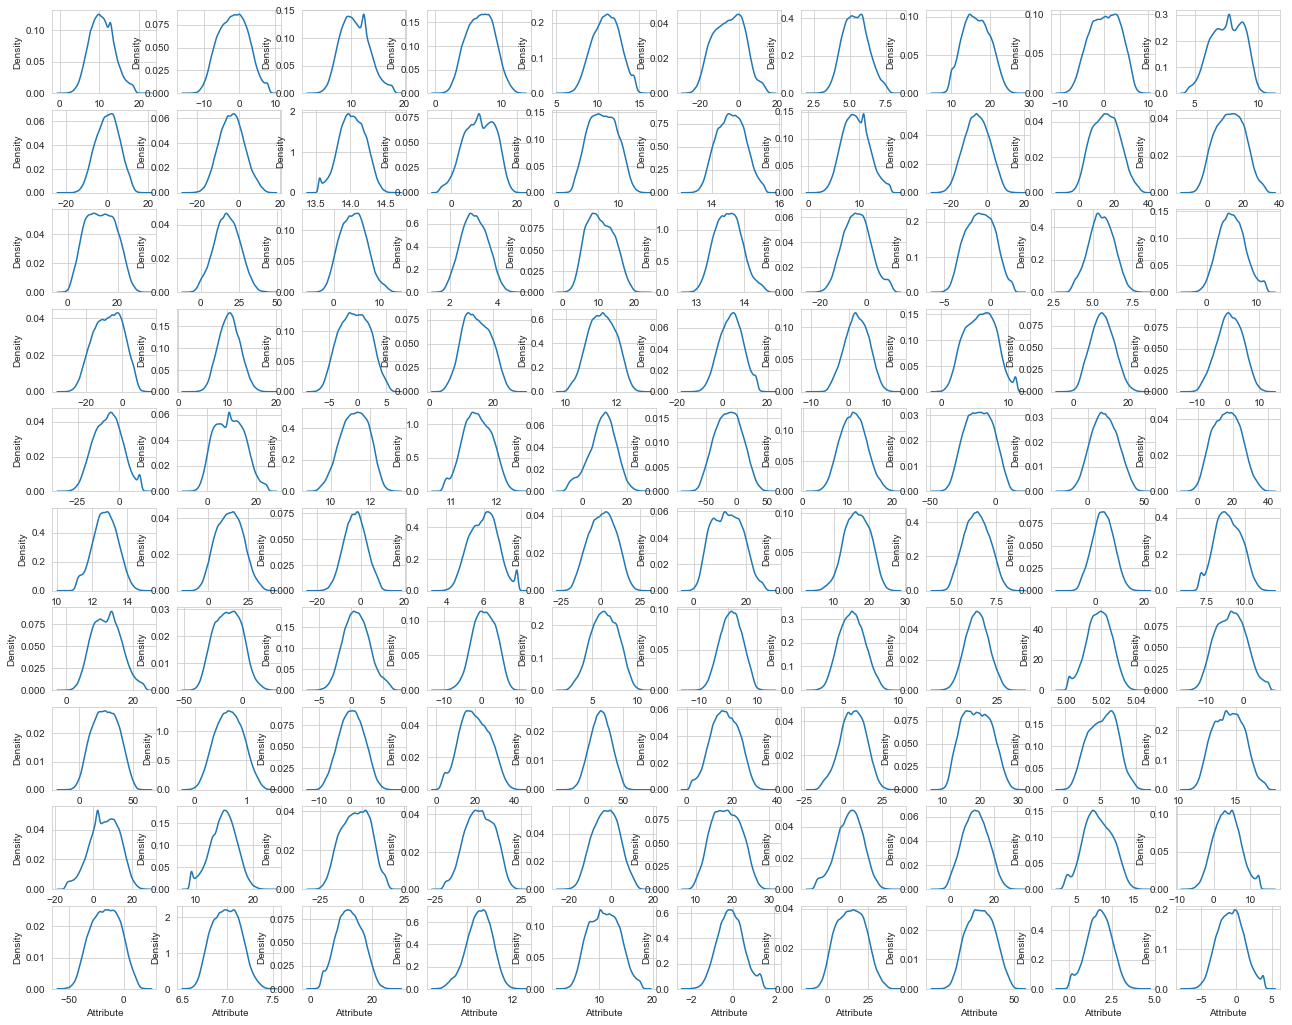

In [18]:
test_features=test_df.columns.values[1:101]
plot_test_features(test_features)

<Figure size 432x288 with 0 Axes>

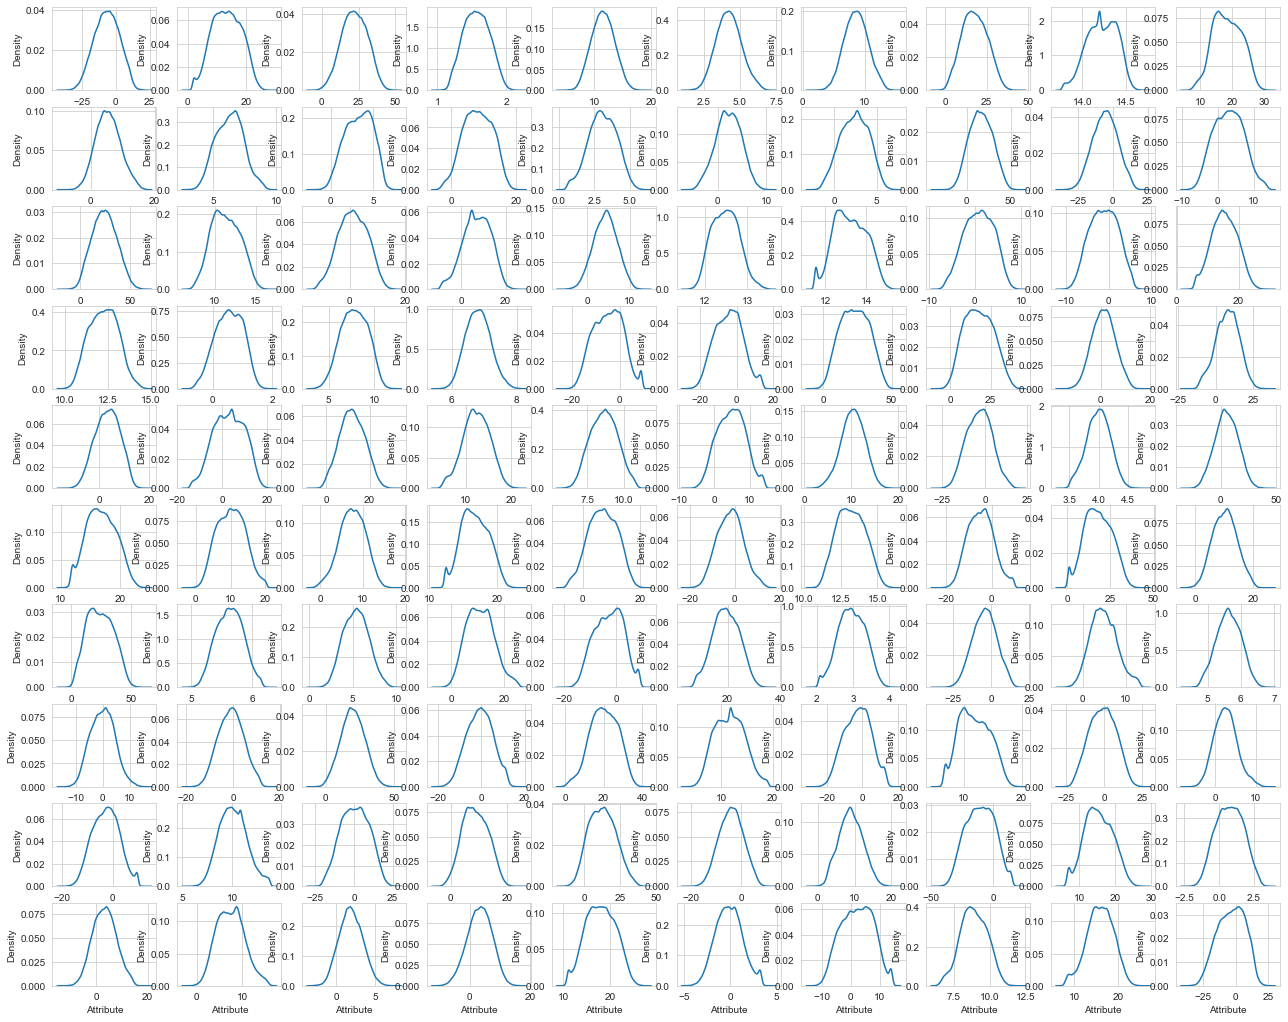

In [19]:
test_features=test_df.columns.values[101:202]
plot_test_features(test_features)

In [20]:
t0 = df[df.target.values == 0]
t1 = df[df.target.values == 1]
t2 = test_df

In [21]:
def plot_dist_at_treino(t0, t1, t2, label1, label2, label3, at_treino):
    i=0
    sns.set_style('whitegrid')
    
    fig=plt.figure()
    ax=plt.subplots(10,10,figsize=(22,18))
    
    for atrib in at_treino:
        i+=1
        plt.subplot(10,10,i)
        sns.distplot(t0[atrib],hist=False,label=label1)
        sns.distplot(t1[atrib],hist=False,label=label2)
        sns.distplot(t2[atrib],hist=False,label=label2)
        sns.distplot(ax=ax[i], x=variável, data=treino,hue=target)
        plt.legend()
        plt.xlabel('Attribute',)
        sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    plt.show()

### Análise das distribuições:
Vamos analisar a distribuição da média, desvio padrão, assimetria e curtose por linha e coluna no dataset.

##### Média:

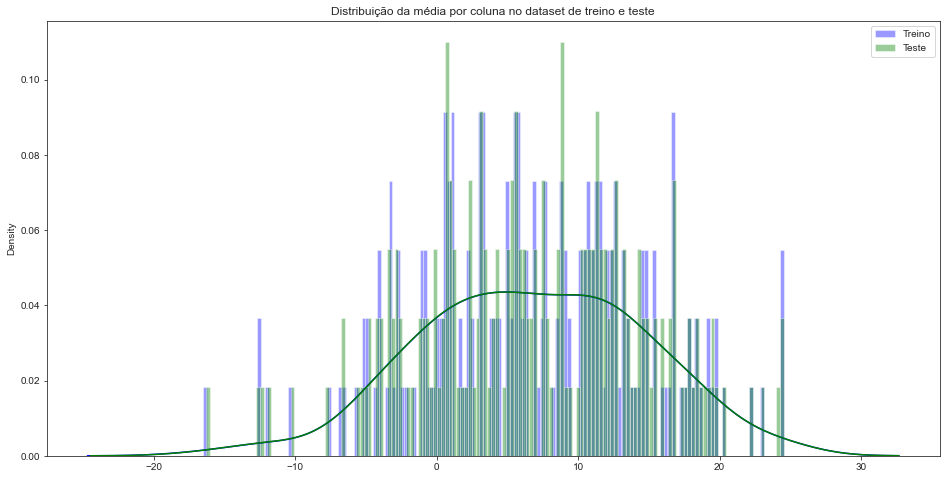

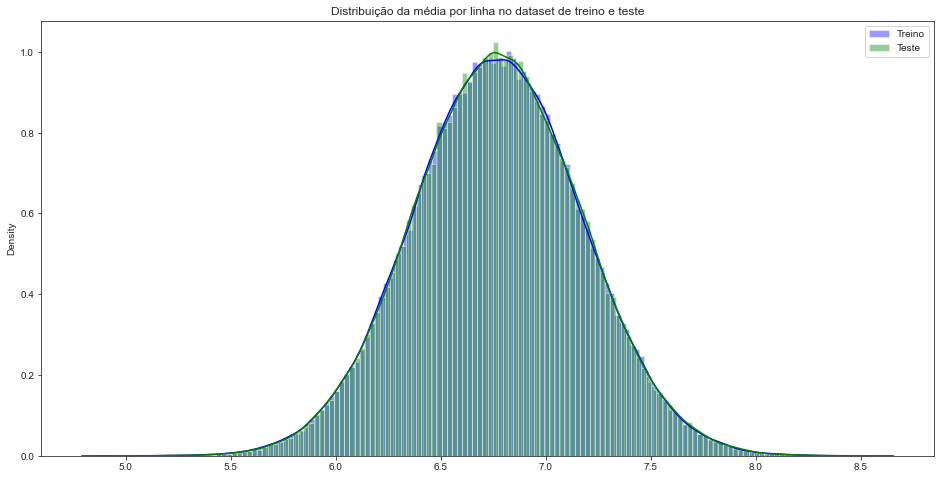

In [22]:
plt.figure(figsize = (16,8))
at_treino = df.columns.values[2:202]
at_test = test_df.columns.values[1:201]
sns.distplot(df[at_treino].mean(axis = 0),color = 'blue', kde = True, bins = 150, label = 'Treino')
sns.distplot(test_df[at_test].mean(axis = 0),color = 'green', kde = True, bins=150, label = 'Teste')
plt.title('Distribuição da média por coluna no dataset de treino e teste')
plt.legend()
plt.show()

plt.figure(figsize = (16,8))
sns.distplot(df[at_treino].mean(axis = 1),color = 'blue', kde = True, bins = 150, label = 'Treino')
sns.distplot(test_df[at_test].mean(axis = 1),color = 'green', kde = True, bins=150, label = 'Teste')
plt.title('Distribuição da média por linha no dataset de treino e teste')
plt.legend()
plt.show()

##### Desvio padrão

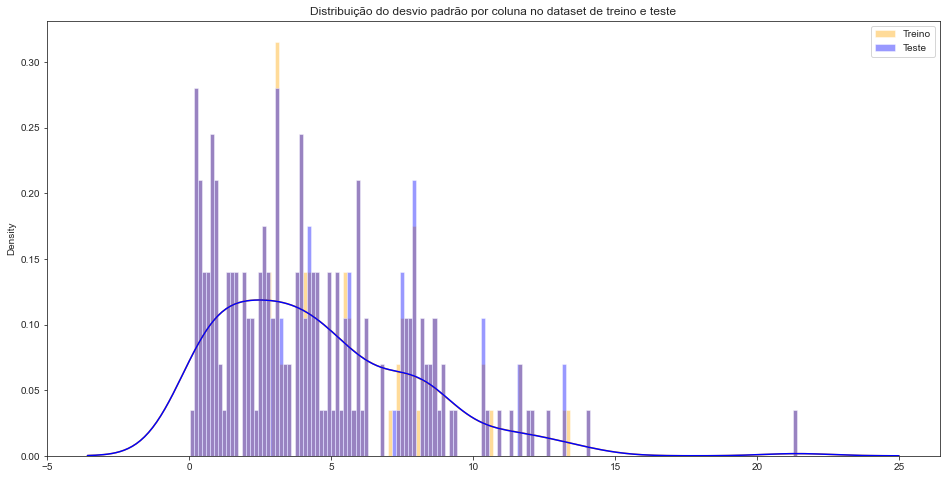

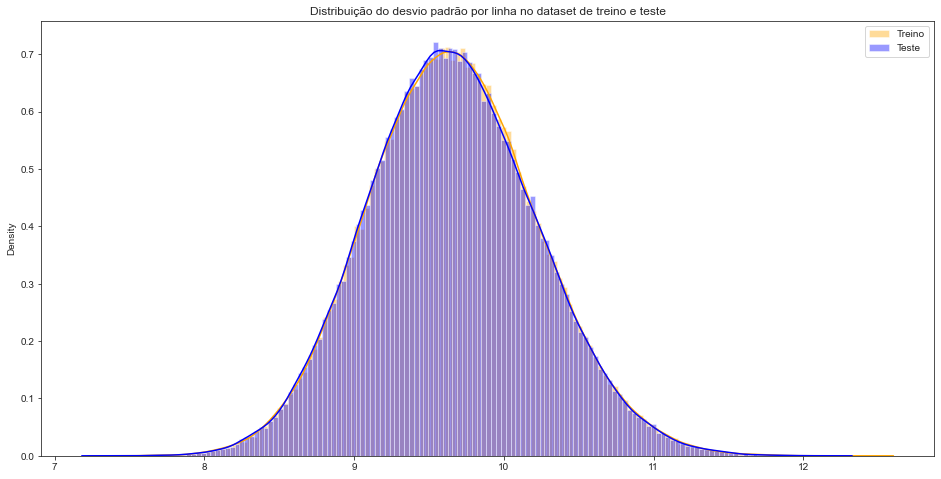

In [23]:
plt.figure(figsize = (16,8))
at_treino = df.columns.values[2:202]
at_test = test_df.columns.values[1:201]
sns.distplot(df[at_treino].std(axis = 0), color='orange',kde=True, bins = 150,label='Treino')
sns.distplot(test_df[at_test].std(axis = 0),color='blue',kde=True, bins = 150,label='Teste')
plt.title('Distribuição do desvio padrão por coluna no dataset de treino e teste')
plt.legend()
plt.show()

plt.figure(figsize = (16,8))
sns.distplot(df[at_treino].std(axis = 1),color = 'orange', kde = True, bins = 150, label = 'Treino')
sns.distplot(test_df[at_test].std(axis = 1),color = 'blue', kde = True, bins = 150, label = 'Teste')
plt.title('Distribuição do desvio padrão por linha no dataset de treino e teste')
plt.legend()
plt.show()

##### Assimetria

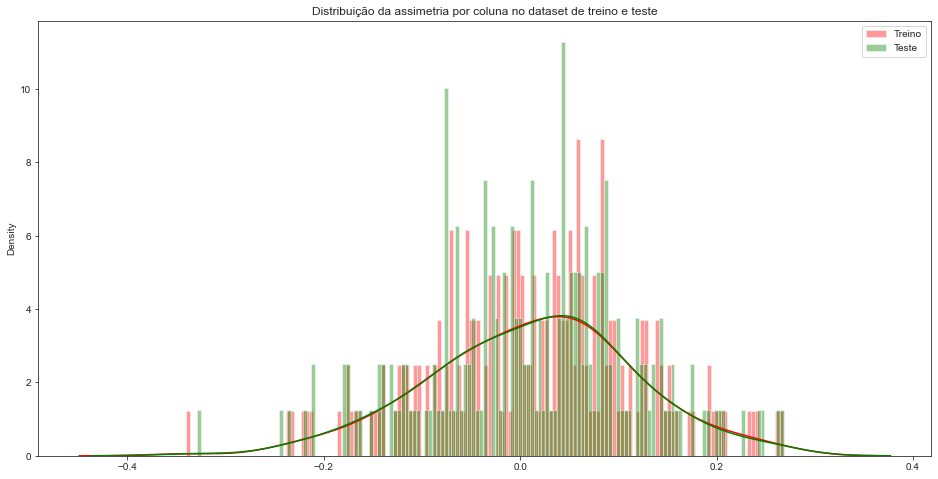

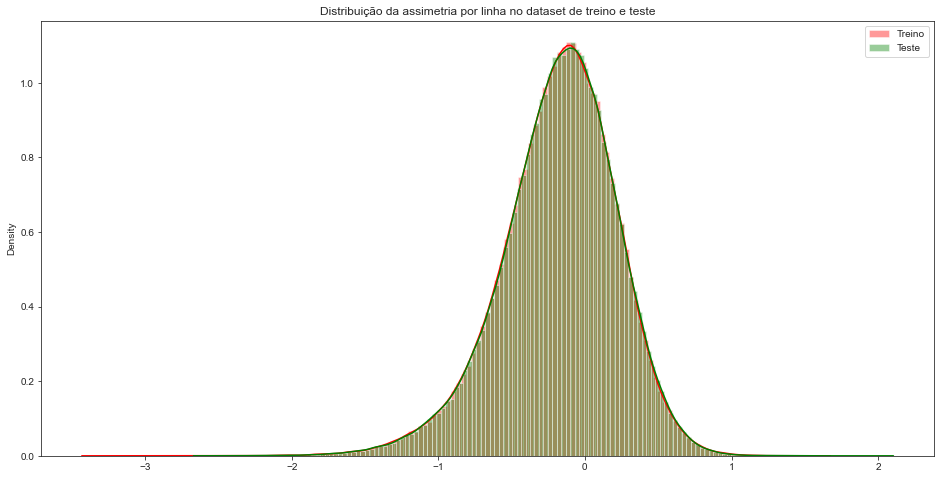

In [24]:
plt.figure(figsize = (16,8))
at_treino = df.columns.values[2:202]
at_test = test_df.columns.values[1:201]
sns.distplot(df[at_treino].skew(axis = 0), color = 'red',kde = True, bins = 150, label = 'Treino')
sns.distplot(test_df[at_test].skew(axis = 0), color = 'green',kde = True, bins = 150, label = 'Teste')
plt.title('Distribuição da assimetria por coluna no dataset de treino e teste')
plt.legend()
plt.show()

plt.figure(figsize = (16,8))
sns.distplot(df[at_treino].skew(axis = 1),color = 'red', kde=True, bins = 150, label = 'Treino')
sns.distplot(test_df[at_test].skew(axis = 1),color = 'green', kde = True, bins=150, label = 'Teste')
plt.title('Distribuição da assimetria por linha no dataset de treino e teste')
plt.legend()
plt.show()

##### Curtose (achatamento da curva)

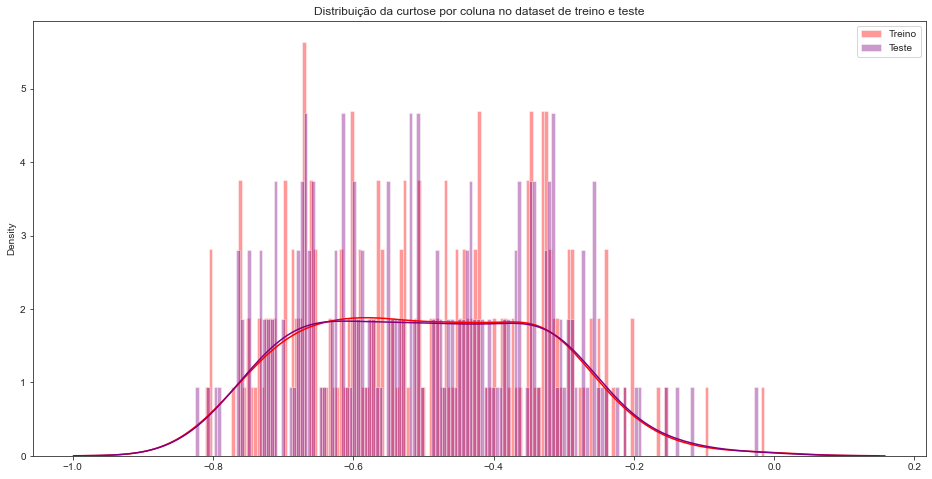

<function matplotlib.pyplot.show(close=None, block=None)>

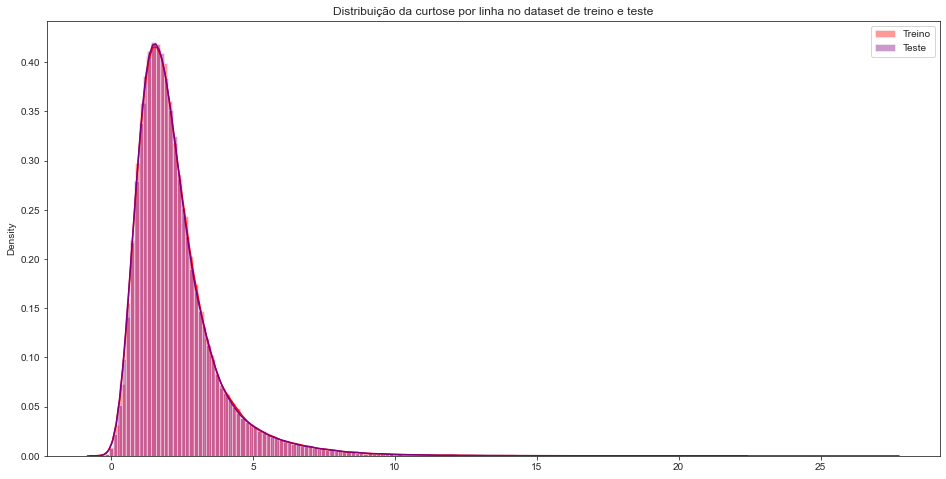

In [25]:
plt.figure(figsize = (16,8))
at_treino = df.columns.values[2:202]
at_test = test_df.columns.values[1:201]
sns.distplot(df[at_treino].kurtosis(axis=0),color='red',kde=True,bins=150,label='Treino')
sns.distplot(test_df[at_test].kurtosis(axis=0),color='purple',kde=True,bins=150,label='Teste')
plt.title('Distribuição da curtose por coluna no dataset de treino e teste')
plt.legend()
plt.show()

plt.figure(figsize=(16,8))
sns.distplot(df[at_treino].kurtosis(axis = 1),color = 'red', kde=True, bins = 150, label = 'Treino')
sns.distplot(test_df[at_test].kurtosis(axis = 1),color = 'purple', kde = True, bins=150, label = 'Teste')
plt.title('Distribuição da curtose por linha no dataset de treino e teste')
plt.legend()
plt.show

#### Correlações nos dados de treino e teste

In [26]:
at_treino = df.columns.values[2:202]
corr_treino = df[at_treino].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
corr_treino = corr_treino[corr_treino['level_0']!=corr_treino['level_1']]
print(corr_treino.head(10))
print(corr_treino.tail(10))

   level_0  level_1             0
0   var_75  var_191  2.703975e-08
1  var_191   var_75  2.703975e-08
2  var_173    var_6  5.942735e-08
3    var_6  var_173  5.942735e-08
4  var_126  var_109  1.313947e-07
5  var_109  var_126  1.313947e-07
6  var_144   var_27  1.772502e-07
7   var_27  var_144  1.772502e-07
8  var_177  var_100  3.116544e-07
9  var_100  var_177  3.116544e-07
       level_0  level_1         0
39790  var_183  var_189  0.009359
39791  var_189  var_183  0.009359
39792  var_174   var_81  0.009490
39793   var_81  var_174  0.009490
39794   var_81  var_165  0.009714
39795  var_165   var_81  0.009714
39796   var_53  var_148  0.009788
39797  var_148   var_53  0.009788
39798   var_26  var_139  0.009844
39799  var_139   var_26  0.009844


In [27]:
at_test = test_df.columns.values[1:201]
corr_test = test_df[at_test].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
corr_test = corr_test[corr_test['level_0']!=corr_test['level_1']]
print(corr_test.head(10))
print(corr_test.tail(10))

   level_0  level_1             0
0  var_154  var_175  1.477268e-07
1  var_175  var_154  1.477268e-07
2  var_188  var_113  1.639749e-07
3  var_113  var_188  1.639749e-07
4  var_131    var_8  4.695407e-07
5    var_8  var_131  4.695407e-07
6   var_60  var_189  9.523709e-07
7  var_189   var_60  9.523709e-07
8  var_159   var_96  1.147835e-06
9   var_96  var_159  1.147835e-06
       level_0  level_1         0
39790  var_122  var_164  0.008513
39791  var_164  var_122  0.008513
39792  var_164    var_2  0.008614
39793    var_2  var_164  0.008614
39794   var_31  var_132  0.008714
39795  var_132   var_31  0.008714
39796   var_96  var_143  0.008829
39797  var_143   var_96  0.008829
39798  var_139   var_75  0.009868
39799   var_75  var_139  0.009868


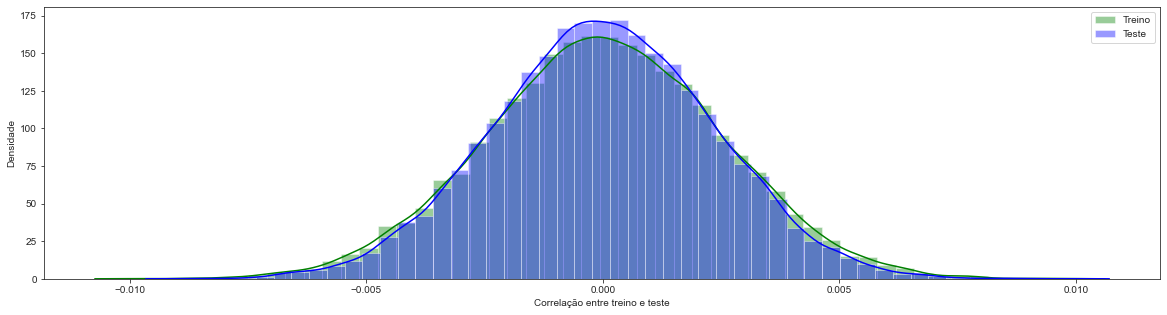

In [28]:
corr_treino = df[at_treino].corr()
corr_treino = corr_treino.values.flatten()
corr_treino = corr_treino[corr_treino!=1]


corr_test = test_df[at_test].corr()
corr_test = corr_test.values.flatten()
corr_test = corr_test[corr_test!=1]

plt.figure(figsize=(20,5))
sns.distplot(corr_treino, color="Green", label="Treino")

sns.distplot(corr_test, color="Blue", label="Teste")
plt.xlabel("Correlação entre treino e teste")
plt.ylabel("Densidade")
plt.legend()

### Visualização das features mais importantes para o modelo

In [29]:
x = df.drop(columns = ['ID_code','target'],axis = 1)
test = test_df.drop(columns = ['ID_code'],axis = 1)
y = df['target']

In [30]:
x_treino, x_test, y_treino, y_test = train_test_split(x,y,random_state=7)

print(f'Shape x_treino:{x_treino.shape}')
print(f'Shape x_test: {x_test.shape}')
print(f'Shape y_treino: {y_treino.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape x_treino:(150000, 200)
Shape x_test: (50000, 200)
Shape y_treino: (150000,)
Shape y_test: (50000,)


In [31]:
rf_model = RandomForestClassifier(n_estimators=10,random_state=7)

rf_model.fit(x_treino, y_treino)

RandomForestClassifier(n_estimators=10, random_state=7)

In [32]:
perm_imp = PermutationImportance(rf_model,random_state=7)

perm_imp.fit(x_test,y_test)

PermutationImportance(estimator=RandomForestClassifier(n_estimators=10,
                                                       random_state=7),
                      random_state=7)

In [33]:
eli5.show_weights(perm_imp,feature_names=x_test.columns.tolist(),top=200)

Weight,Feature
0.0002 ± 0.0002,var_81
0.0001 ± 0.0001,var_184
0.0001 ± 0.0001,var_118
0.0001 ± 0.0001,var_156
0.0001 ± 0.0002,var_146
0.0001 ± 0.0000,var_143
0.0001 ± 0.0000,var_14
0.0001 ± 0.0001,var_22
0.0001 ± 0.0000,var_150
0.0001 ± 0.0001,var_65


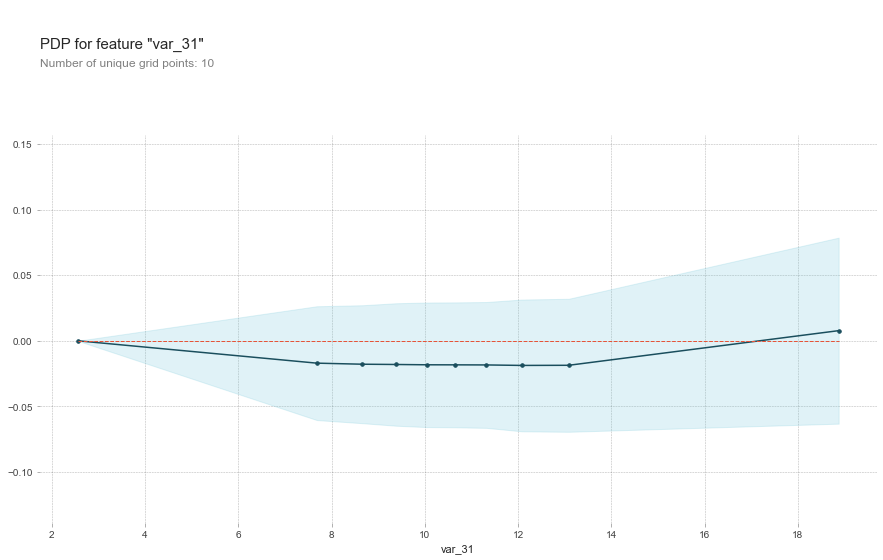

In [34]:
features=[v for v in x_test.columns if v not in ['ID_code','target']]
pdp_data=pdp.pdp_isolate(rf_model,dataset=x_test ,model_features=features, feature='var_31')

pdp.pdp_plot(pdp_data,'var_31')
plt.show()

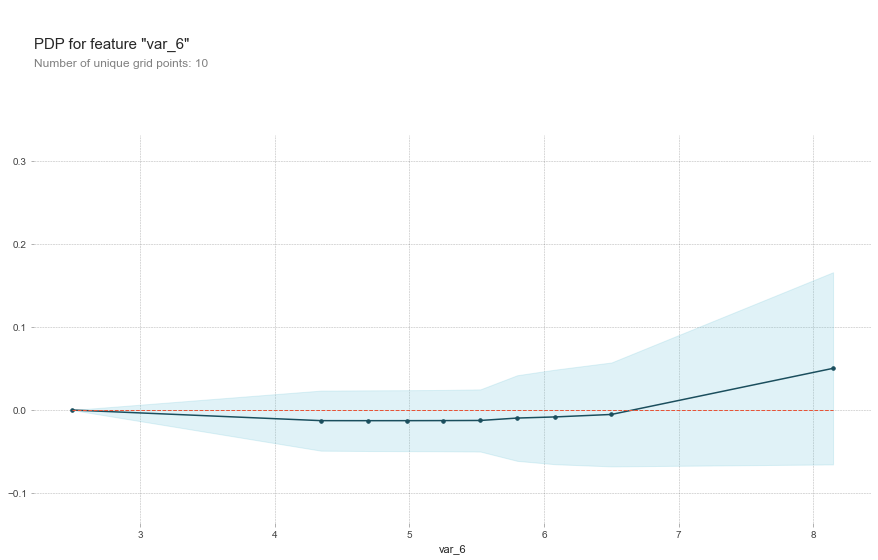

In [35]:
pdp_data=pdp.pdp_isolate(rf_model,dataset=x_test,model_features=features,feature='var_6')

pdp.pdp_plot(pdp_data,'var_6')
plt.show()

In [36]:
skfold = StratifiedKFold(n_splits = 5,random_state = 7, shuffle = True)
for train_index, test_index in skfold.split(x,y):
    x_treino, x_test = x.iloc[train_index], x.iloc[test_index]
    y_treino, y_test = y.iloc[train_index], y.iloc[test_index]

print(f'Shape x_treino:{x_treino.shape}')
print(f'Shape x_test: {x_test.shape}')
print(f'Shape y_treino: {y_treino.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape x_treino:(160000, 200)
Shape x_test: (40000, 200)
Shape y_treino: (160000,)
Shape y_test: (40000,)


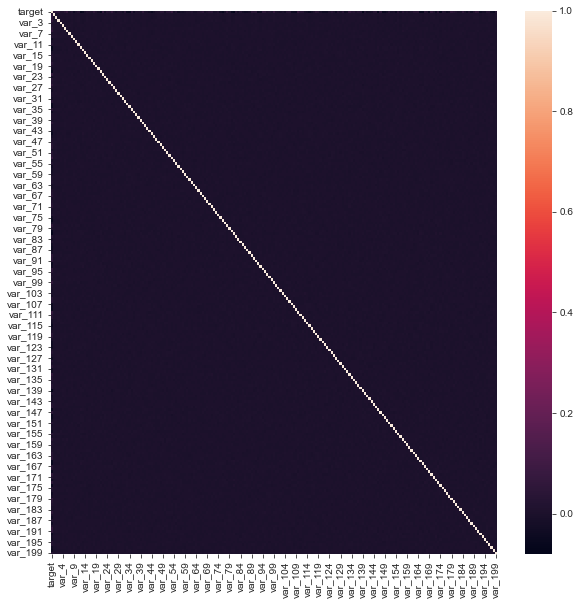

In [37]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr())
plt.show()

### Feature Selection: Boruta

Vamos utilizar o algoritmo boruta para selecionar as features mais importantes para o modelo.
Por que Boruta?
Com o algoritmo boruta, ao invés de selecionarmos um threshold por arbitrariedade levamos em consideração conceitos estatísticos de distribuição para selecionar as features.

In [38]:
x = df.drop(columns = ['ID_code','target'],axis = 1)
test = test_df.drop(columns = ['ID_code'],axis = 1)
y = df['target']

In [39]:
hits = np.zeros((len(x.columns)))

for iter_ in range(20):
    np.random.seed(iter_)
    x_shadow = x.apply(np.random.permutation)
    x_shadow.columns = ['shadow_' + feat for feat in x.columns]
    x_boruta = pd.concat([x, x_shadow], axis = 1)
    x_treino, x_test, y_treino, y_test = train_test_split(x_boruta,y,random_state=iter_)
    

    lgbc = LGBMClassifier(boosting_type='rf', bagging_freq=1, bagging_fraction=0.5, n_estimators=1000, random_state=7) 
    lgbc.fit(x_treino, y_treino, eval_set=[(x_treino, y_treino), (x_test, y_test)], 
            callbacks=[early_stopping(100)])

    feat_imp_X = lgbc.feature_importances_[:len(x.columns)]
    feat_imp_shadow = lgbc.feature_importances_[len(x.columns):]

    hits += feat_imp_X > feat_imp_shadow.max()

[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.294672	valid_1's binary_logloss: 0.303315
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.295973	valid_1's binary_logloss: 0.299439
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.293354	valid_1's binary_logloss: 0.303669
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.293413	valid_1's binary_logloss: 0.304627
Training until validation scores don't improve for 100 rounds
Early stopping, be

In [40]:
hits

array([20., 20., 20.,  0.,  0., 13., 20.,  0.,  1., 20.,  0.,  1., 20.,
       20.,  0.,  0.,  0.,  0., 19.,  0.,  2., 20., 20.,  5.,  1.,  0.,
       20.,  1.,  5.,  0.,  0.,  0.,  9., 20., 20.,  2.,  9.,  0.,  0.,
        0., 20.,  0.,  0.,  9., 20.,  1.,  0.,  0.,  1., 11.,  0.,  7.,
        5., 20.,  1.,  0., 14.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., 13.,  0.,  0.,  1.,  4.,  0.,  0.,  0., 18., 20.,  0.,
       20.,  0., 20., 20.,  1.,  1.,  1.,  3., 20., 14.,  2., 17.,  1.,
       18., 20., 13., 20., 19.,  0.,  0.,  0., 20.,  0.,  0.,  0.,  0.,
        0.,  0.,  8.,  7., 20., 20., 20.,  0.,  0.,  0.,  5., 20.,  0.,
        0., 17., 10.,  0., 20., 12., 19.,  0.,  7.,  0., 20.,  2.,  0.,
        9.,  4.,  3., 20.,  0.,  2.,  0.,  0.,  0., 20.,  0., 11.,  0.,
        1.,  0.,  7., 20., 18., 20., 15.,  1.,  9.,  0.,  0., 20., 16.,
        3., 11.,  0.,  0.,  0.,  0.,  6., 10., 20., 20., 20.,  1.,  0.,
       20., 20.,  0., 12., 16., 20.,  0.,  0., 20.,  1., 20.,  9

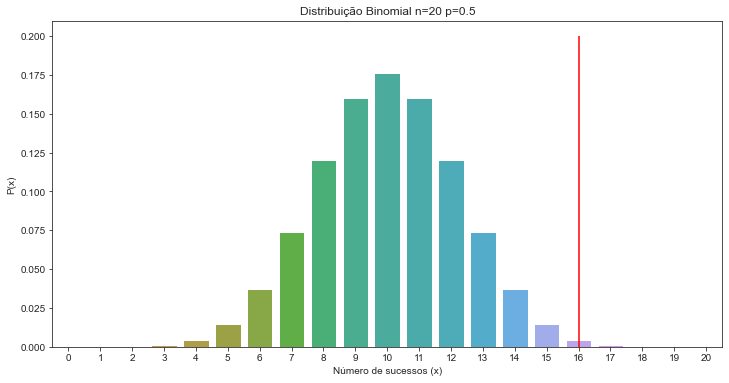

In [41]:
n = 20
p = 0.5

binomial_values = list( np.arange(n+1) )
dist = [ sp.stats.binom.pmf(val, n, p) for val in binomial_values]

plt.figure(figsize=(12,6))
plt.title('Distribuição Binomial n=20 p=0.5')
plt.xlabel('Número de sucessos (x)')
plt.ylabel('P(x)')
plt.vlines(16,0,0.2, color='red')
sns.barplot(binomial_values, dist);

Como podemos considerar cada iteração como um Ensaio de Bernoulli e repetimos por 20 vezes, podemos considerar uma distribuição binomial com n=20 para tomarmos a decisão das features selecionadas.

### Drop das features
Após selecionadas as features que não tem poder preditivo, vamos criar um novo dataset para trabalhar apenas com as melhores features.

In [42]:
df_hits = pd.concat((pd.Series(x.columns, name="Columns"), pd.Series(hits, name="hits")), axis=1)
df_hits

,Columns,hits
0,var_0,20.0
1,var_1,20.0
2,var_2,20.0
3,var_3,0.0
4,var_4,0.0
...,...,...
195,var_195,7.0
196,var_196,4.0
197,var_197,10.0
198,var_198,20.0


In [43]:
drop_df = list(df_hits[df_hits['hits']<5]['Columns'])
drop_df

['var_3',
 'var_4',
 'var_7',
 'var_8',
 'var_10',
 'var_11',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_19',
 'var_20',
 'var_24',
 'var_25',
 'var_27',
 'var_29',
 'var_30',
 'var_31',
 'var_35',
 'var_37',
 'var_38',
 'var_39',
 'var_41',
 'var_42',
 'var_45',
 'var_46',
 'var_47',
 'var_48',
 'var_50',
 'var_54',
 'var_55',
 'var_57',
 'var_58',
 'var_59',
 'var_60',
 'var_61',
 'var_62',
 'var_63',
 'var_64',
 'var_65',
 'var_66',
 'var_68',
 'var_69',
 'var_70',
 'var_71',
 'var_72',
 'var_73',
 'var_74',
 'var_77',
 'var_79',
 'var_82',
 'var_83',
 'var_84',
 'var_85',
 'var_88',
 'var_90',
 'var_96',
 'var_97',
 'var_98',
 'var_100',
 'var_101',
 'var_102',
 'var_103',
 'var_104',
 'var_105',
 'var_111',
 'var_112',
 'var_113',
 'var_116',
 'var_117',
 'var_120',
 'var_124',
 'var_126',
 'var_128',
 'var_129',
 'var_131',
 'var_132',
 'var_134',
 'var_135',
 'var_136',
 'var_137',
 'var_138',
 'var_140',
 'var_142',
 'var_143',
 'var_144',
 'var_150',
 'var_152',
 'var_1

In [44]:
df = df.drop(drop_df, axis=1)
test_df = test_df.drop(drop_df, axis=1)

In [45]:
df.head()

,ID_code,target,var_0,var_1,var_2,var_5,var_6,var_9,var_12,var_13,...,var_180,var_184,var_186,var_188,var_190,var_191,var_192,var_195,var_197,var_198
0,train_0,0,8.9255,-6.7863,11.9081,-9.2834,5.1187,5.7470,14.0137,0.5745,...,-8.4051,25.8398,11.8411,17.5743,4.4354,3.9642,3.1364,-2.3978,8.5635,12.7803
1,train_1,0,11.5006,-4.1473,13.8588,7.0433,5.6208,8.0851,14.0239,8.4135,...,-5.5937,22.5441,7.6543,13.3175,7.6421,7.7214,2.5837,2.0339,8.7889,18.3560
2,train_2,0,8.6093,-2.7457,12.0805,-9.0837,6.9427,5.9525,14.1929,7.3124,...,-4.2935,23.0866,5.3745,10.1934,2.9057,9.7905,1.6704,3.1417,8.2675,14.7222
3,train_3,0,11.0604,-2.1518,8.9522,-1.8361,5.8428,8.2450,13.8463,11.9704,...,-3.7546,-0.4639,7.9336,12.4124,4.4666,4.7433,0.7178,-1.2706,10.2922,17.9697
4,train_4,0,9.8369,-1.4834,12.8746,2.4486,5.9405,7.6784,13.8481,7.8895,...,-7.6938,11.8503,6.4209,16.0201,-1.4905,9.5214,-0.1508,-1.5121,9.5031,17.9974


### Treinando o modelo de LightGBM

In [46]:
x = df.drop(columns = ['ID_code','target'],axis = 1)
y = df['target']

In [47]:
x_treino, x_test, y_treino, y_test = train_test_split(x,y,random_state=7)

In [48]:
lgb_train=lgb.Dataset(x_treino,label=y_treino)

lgb_valid=lgb.Dataset(x_test,label=y_test)

In [49]:
lgbm= LGBMClassifier(n_estimators=1000, random_state=7) 
lgbm.fit(x_treino, y_treino, eval_set=[(x_treino, y_treino), (x_test, y_test)], callbacks=[early_stopping(100), log_evaluation(10)])
lgbm

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.296093	valid_1's binary_logloss: 0.301468
[20]	training's binary_logloss: 0.277608	valid_1's binary_logloss: 0.286557
[30]	training's binary_logloss: 0.263602	valid_1's binary_logloss: 0.276344
[40]	training's binary_logloss: 0.25189	valid_1's binary_logloss: 0.268
[50]	training's binary_logloss: 0.242166	valid_1's binary_logloss: 0.261393
[60]	training's binary_logloss: 0.233877	valid_1's binary_logloss: 0.256
[70]	training's binary_logloss: 0.226703	valid_1's binary_logloss: 0.251667
[80]	training's binary_logloss: 0.220365	valid_1's binary_logloss: 0.247888
[90]	training's binary_logloss: 0.214473	valid_1's binary_logloss: 0.244294
[100]	training's binary_logloss: 0.209309	valid_1's binary_logloss: 0.241256
[110]	training's binary_logloss: 0.204633	valid_1's binary_logloss: 0.238741
[120]	training's binary_logloss: 0.200309	valid_1's binary_logloss: 0.236458
[130]	training's binary_loglos

LGBMClassifier(n_estimators=1000, random_state=7)

In [50]:
X_test=test_df.drop(['ID_code'],axis=1)

lgbm_predict=lgbm.predict(X_test,random_state=7,num_iteration=lgbm.best_iteration_)

print(lgbm_predict)

[0 0 0 ... 0 0 0]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

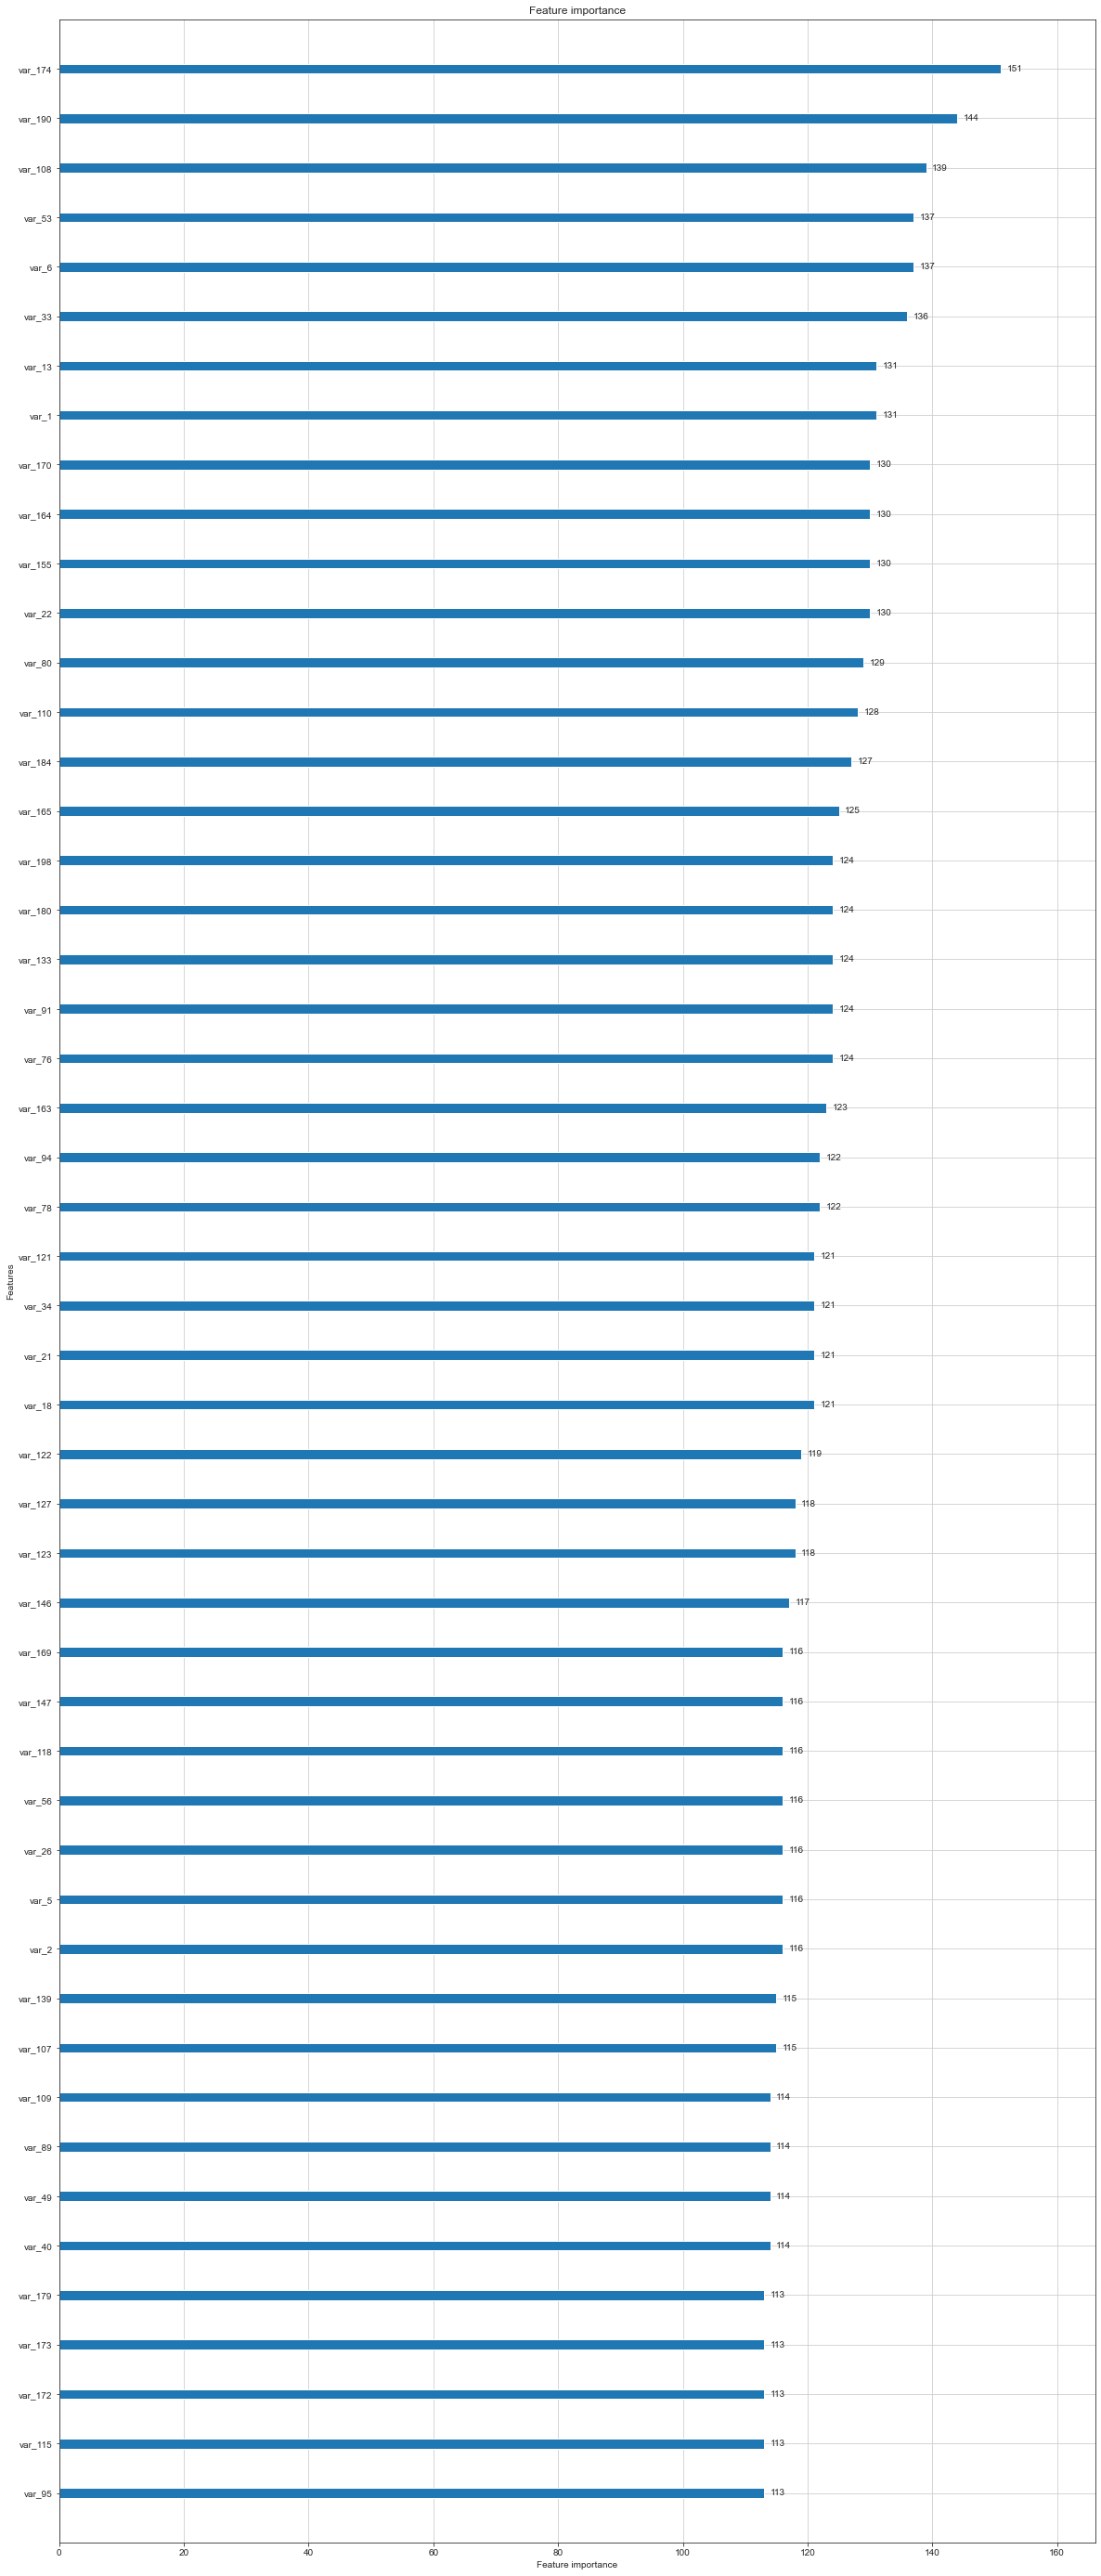

In [51]:
lgb.plot_importance(lgbm,max_num_features=50,importance_type="split",figsize=(20,50))

In [52]:
sub_df=pd.DataFrame({'ID_code':test_df['ID_code'].values})
sub_df['lgbm_predict']=lgbm_predict
sub_df.to_csv('submission.csv',index=False)
sub_df.head()

,ID_code,lgbm_predict
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


### PCA

Tentaremos uma outra alternativa de feature selection com PCA.

In [53]:
dados = pd.read_csv('C:/Users/Urbanek/Documents/Data Science/Datasets/Santander Customer Transaction Prediction Dataset/train.csv')

In [54]:
x = dados.drop(columns = ['ID_code','target'],axis = 1)
y = dados['target']

In [55]:
norm = MinMaxScaler(feature_range=(0, 1))
x_norm = norm.fit_transform(x)

pca = PCA(n_components= 90)
x_pca = pca.fit_transform(x_norm)

x_treino, x_test, y_treino, y_test = train_test_split(x,y,random_state=7)

lgb_train=lgb.Dataset(x_treino,label=y_treino)
lgb_valid=lgb.Dataset(x_test,label=y_test)

lgbm= LGBMClassifier(n_estimators=1000, random_state=7) 
lgbm.fit(x_treino, y_treino, eval_set=[(x_treino, y_treino), (x_test, y_test)], callbacks=[early_stopping(100), log_evaluation(10)])
lgbm

Training until validation scores don't improve for 100 rounds
[10]	training's binary_logloss: 0.296093	valid_1's binary_logloss: 0.301468
[20]	training's binary_logloss: 0.277776	valid_1's binary_logloss: 0.287005
[30]	training's binary_logloss: 0.26328	valid_1's binary_logloss: 0.27599
[40]	training's binary_logloss: 0.251588	valid_1's binary_logloss: 0.267618
[50]	training's binary_logloss: 0.241792	valid_1's binary_logloss: 0.260851
[60]	training's binary_logloss: 0.233172	valid_1's binary_logloss: 0.255364
[70]	training's binary_logloss: 0.225615	valid_1's binary_logloss: 0.250811
[80]	training's binary_logloss: 0.218684	valid_1's binary_logloss: 0.246545
[90]	training's binary_logloss: 0.212494	valid_1's binary_logloss: 0.243123
[100]	training's binary_logloss: 0.20687	valid_1's binary_logloss: 0.24009
[110]	training's binary_logloss: 0.201625	valid_1's binary_logloss: 0.237389
[120]	training's binary_logloss: 0.196805	valid_1's binary_logloss: 0.23497
[130]	training's binary_logl

LGBMClassifier(n_estimators=1000, random_state=7)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

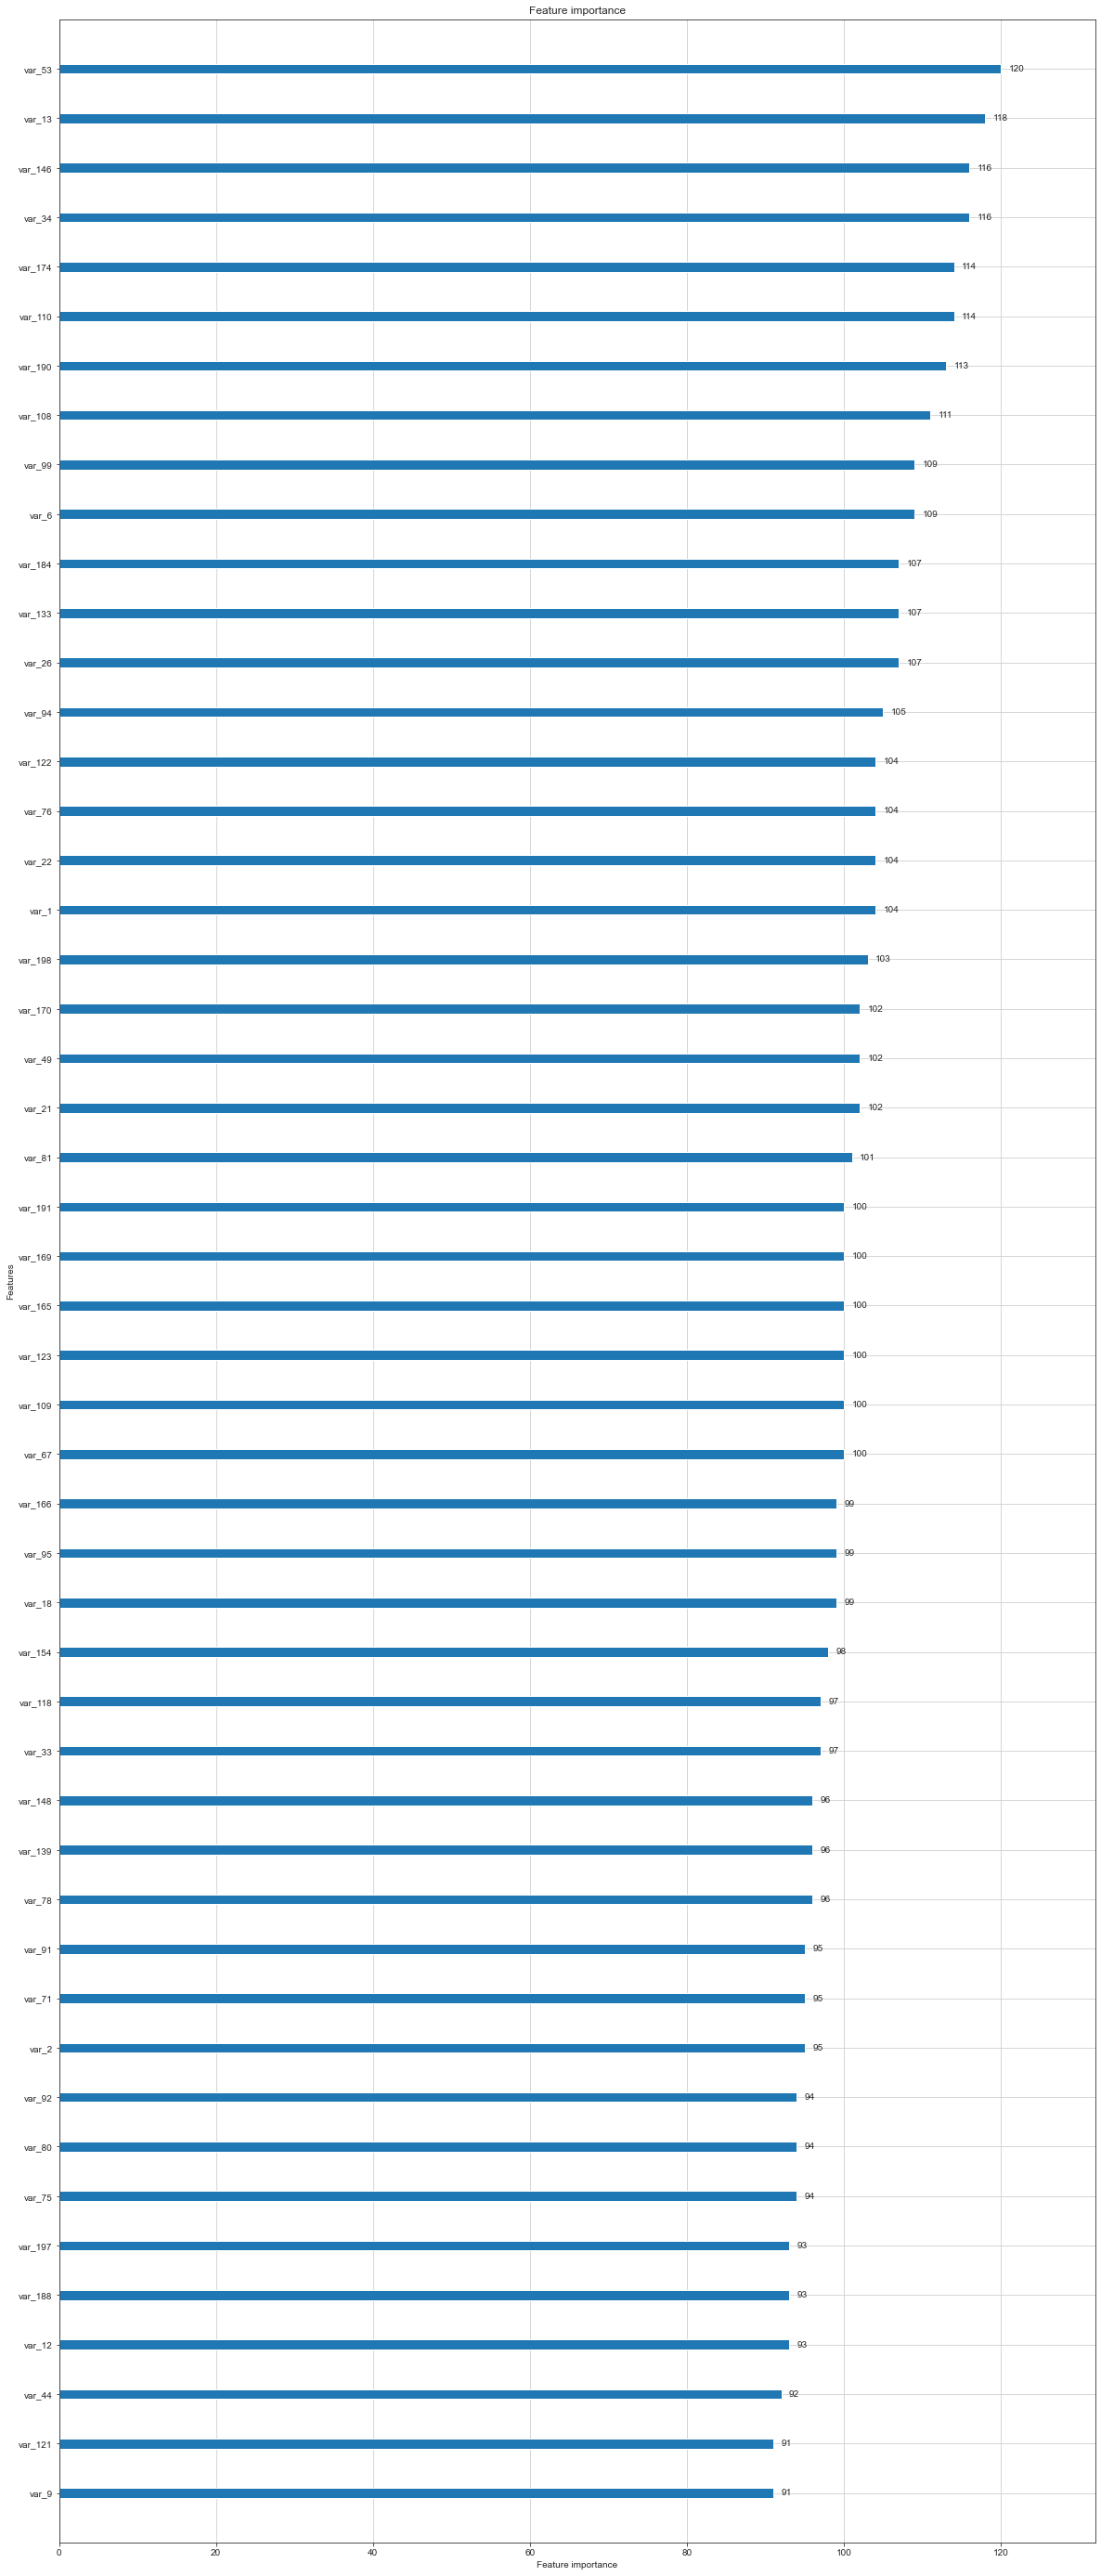

In [56]:
lgb.plot_importance(lgbm,max_num_features=50,importance_type="split",figsize=(20,50))

In [57]:
test_df = pd.read_csv('C:/Users/Urbanek/Documents/Data Science/Datasets/Santander Customer Transaction Prediction Dataset/test.csv')
X_test=test_df.drop(['ID_code'],axis=1)

norm = MinMaxScaler(feature_range=(0, 1))
x_norm = norm.fit_transform(X_test)

pca = PCA(n_components= 90)
x_pca = pca.fit_transform(x_norm)


lgbm_predict=lgbm.predict(X_test,random_state=7,num_iteration=lgbm.best_iteration_)

print(lgbm_predict)

[0 0 0 ... 0 0 0]


In [59]:
sub_df=pd.DataFrame({'ID_code':test_df['ID_code'].values})
sub_df['lgbm_predict']=lgbm_predict
sub_df.to_csv('submission_pca.csv',index=False)
sub_df.head()

,ID_code,lgbm_predict
0,test_0,0
1,test_1,0
2,test_2,0
3,test_3,0
4,test_4,0


Houve um bom tradeoff com o algoritmo de PCA que apresentou uma performance melhor entretanto demorou um pouco mais para rodar.